In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

#BenchmarkLQ_Mathematica
#MUST AGREE WITH MATHEMATICA PARAMETERS#

#MODEL PARAMETERS
#Model parameters: The parameter l is introduced in the space-variable. 
#m0 is supported \in (-l,l)#
T = 1.; Gamma = np.exp(1) ; Zeta = 5/6; Eta = 1.; Kappa = 1/6; bx0 = -1/4; l = 1.; c = 1.;
q0 = 1/2; bq = 1/4;

#DISCRETIZATION PARAMETERS
#N number of agents, M  number of time steps#
N = 3; M = 30; 
h = T/M; timesteps = np.linspace(0, T-h, M); timestepsT=np.append(timesteps,T)
tf.random.set_seed(10)

#MANUAL INSERTION OF THE EXACT PRICE...
PriceExact=0.015328310048810096*(100.16506721348814 - 10.87312731383618*timesteps + 8.154845485377136*timesteps**2)

#MANUAL INSERTION OF THE OPTIMAL TRAJECTORIES AND VELOCITIES...
OptimalXX=np.array([0.21912572159721186/2.718281828459045**(1.*timestepsT) - 0.029339477459567324*2.718281828459045**timestepsT + 0.25*timestepsT,
                    0.9238645303924419/2.718281828459045**(1.*timestepsT) - 0.07341437560229339*2.718281828459045**timestepsT + 0.24999999999999997*timestepsT,
                    -1.8929902519896533/2.718281828459045**(1.*timestepsT) + 0.1027538530618607*2.718281828459045**timestepsT + 0.25*timestepsT
                   ])
OptimalVV=np.array([0.25 - 0.21912572159721186/2.718281828459045**(1.*timesteps) - 0.029339477459567324*2.718281828459045**timesteps,
                    0.24999999999999997 - 0.9238645303924419/2.718281828459045**(1.*timesteps) -  0.07341437560229339*2.718281828459045**timesteps,
                    0.25 + 1.8929902519896533/2.718281828459045**(1.*timesteps) + 0.1027538530618607*2.718281828459045**timesteps  
                   ])

#READING PRICES FROM MATHEMATICA OUTPUT...
DiscreteTreeprice = np.loadtxt("DiscreteTreeprice.txt");
DiscreteHJprice = np.loadtxt("DiscreteHJprice.txt");
#READING INITIAL CONDITIONS FROM MATHEMATICA...
x0 = np.loadtxt("x0.txt");
x0=tf.convert_to_tensor(x0, dtype=tf.float32)


In [27]:
#Declare Terminal Cost uT#
def uT(x):
    return (Gamma/2)*(tf.math.square(x - Zeta))

#Declare initial m#
#Not implemented yet#

#SET SUPPLY explicit#
def Q(t):
    return (q0-bq)*np.exp(-t)+bq

#Declare running cost
def L(x,v):
    return tf.add((Eta/2)*(tf.math.square(x - Kappa)),
                  (c/2)*tf.math.square(v))

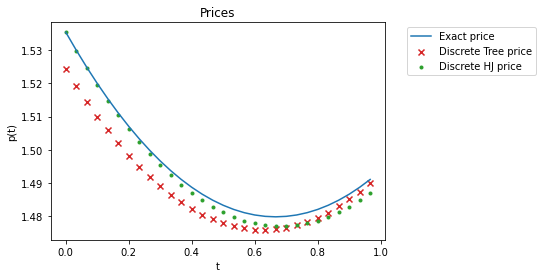

In [28]:
# Initiate plot object
plt.scatter(timesteps, DiscreteTreeprice, label = "Discrete Tree price",color ='tab:red', marker='x')
plt.scatter(timesteps, DiscreteHJprice, label = "Discrete HJ price",color ='tab:green', marker='.')
plt.plot(timesteps, PriceExact, label = "Exact price")
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.xlabel('t');
plt.ylabel('p(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Prices')
plt.show()


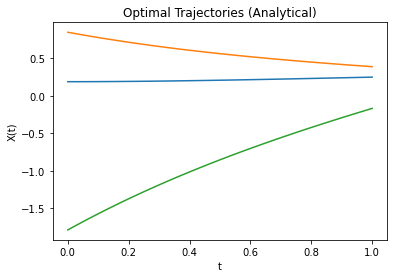

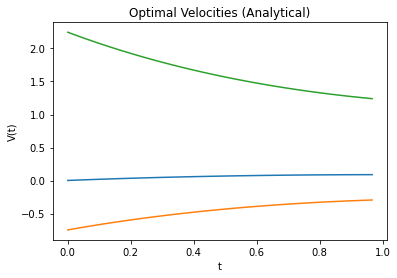

In [29]:
# Initiate plot object
plt.plot(timestepsT, OptimalXX.T)
plt.xlabel('t');
plt.ylabel('X(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Optimal Trajectories (Analytical)')
plt.show()


OptimalVV=np.array([0.25 - 0.21912572159721186/2.718281828459045**(1.*timesteps) - 0.029339477459567324*2.718281828459045**timesteps,
                    0.24999999999999997 - 0.9238645303924419/2.718281828459045**(1.*timesteps) -  0.07341437560229339*2.718281828459045**timesteps,
                    0.25 + 1.8929902519896533/2.718281828459045**(1.*timesteps) + 0.1027538530618607*2.718281828459045**timesteps  
                   ])
# Initiate plot object
plt.plot(timesteps, OptimalVV.T)
plt.xlabel('t');
plt.ylabel('V(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Optimal Velocities (Analytical)')
plt.show()


In [30]:
#NN parameters
learning_rate = 0.01
training_steps = 3001
display_step = 200
#Weights for the losses
aVariational=0.01
aBalance=0.4

# Create model
multilayer_perceptron=tf.keras.Sequential()
multilayer_perceptron.add(tf.keras.Input(shape=(N+1,))) #N positions + time
multilayer_perceptron.add(Dense(256,activation='sigmoid')) #Layer 1
#multilayer_perceptron.add(Dense(32,input_dim=(1),activation='sigmoid')) #Layer 1
multilayer_perceptron.add(Dense(256,activation='sigmoid')) #Layer 2
multilayer_perceptron.add(Dense(256,activation='sigmoid')) #Layer 3
multilayer_perceptron.add(Dense(256,activation='sigmoid')) #Layer 4
multilayer_perceptron.add(Dense(N,activation=None)) #Layer Output N velocities
multilayer_perceptron.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               1280      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 771       
Total params: 199,427
Trainable params: 199,427
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Custom loss equals the variational cost for the N agents
#Impose balance by loss
def custom_loss(NN):
    positions=x0
    #summation is for the variational cost
    summation = []
    #balanceloss is for the balance constraint
    balanceloss=[]
    
    #initialize time 0
    velocities=NN(tf.concat([tf.constant([[0.]],dtype='float32'),tf.reshape(x0,[1,N])],axis=1))
    runningcost0=[L(x0[i],velocities[0,i])*h for i in range(0,N)]
    summation.append(tf.reshape(tf.math.reduce_mean(runningcost0,keepdims=True),[1,1]))
    balanceloss.append(tf.reshape(tf.math.square(tf.math.reduce_mean(velocities)-Q(0)),[1,1]))

    # The mean over players is computed per time step. Then we sum over timesteps
    
    #Compute runing cost per time t in (h,...,T-h)
    for t in timesteps[1:M]: 
        #Update positions using Forward dynamics. This position corresponds to the current time t
        positions=tf.add(positions,velocities*h)
        #Update velocities using current t,x and N
        velocities=NN(tf.concat([tf.constant([[t]],dtype='float32'),tf.reshape(positions,[1,N])],axis=1))
        #Compute cost and append
        runningcost=[L(positions[0,i],velocities[0,i])*h for i in range(0,N)]
        summation.append(tf.reshape(tf.math.reduce_mean(runningcost,keepdims=True),[1,1]))
        balanceloss.append(tf.reshape(tf.math.square(tf.math.reduce_mean(velocities)-Q(t)),[1,1]))
    
    #Compute the terminal cost
    #Update to get terminal position
    positions=tf.add(positions,velocities*h)
    terminalcost=tf.reshape(tf.reduce_mean([uT(positions[0,i]) for i in range(0,N)]),[1,1])
    summation.append(terminalcost)
    
    return tf.math.reduce_sum(summation),tf.math.reduce_mean(balanceloss),summation,balanceloss
#_sum vs _mean

loss after iteration 0: 23.300941 12.4778


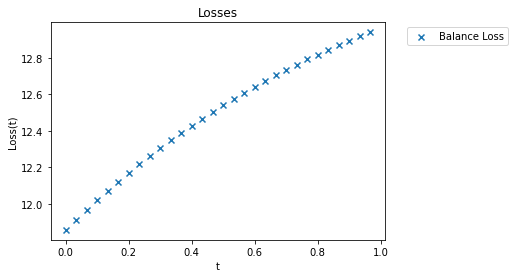

loss after iteration 200: 1.445916 0.00242589


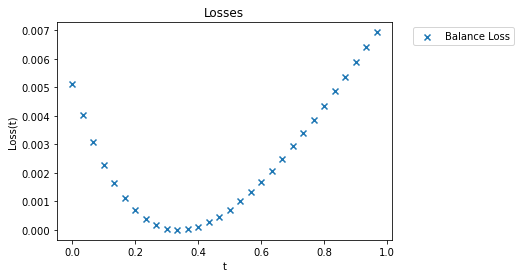

loss after iteration 400: 1.445876 0.00242384


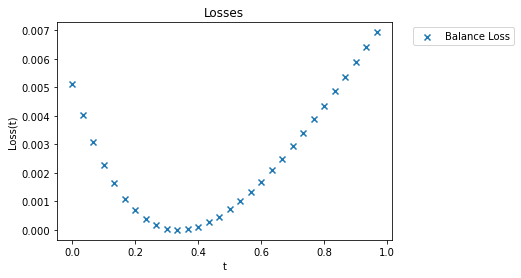

loss after iteration 600: 1.445902 0.00240881


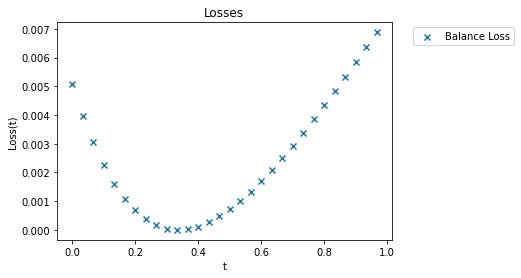

loss after iteration 800: 1.439399 0.000338603


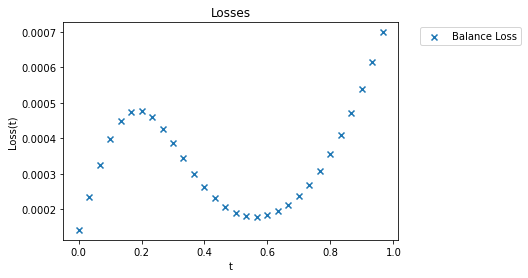

loss after iteration 1000: 1.426964 0.000322753


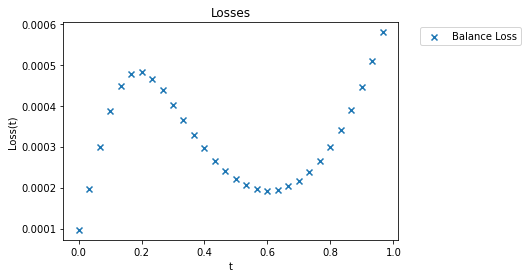

loss after iteration 1200: 1.426481 0.000313443


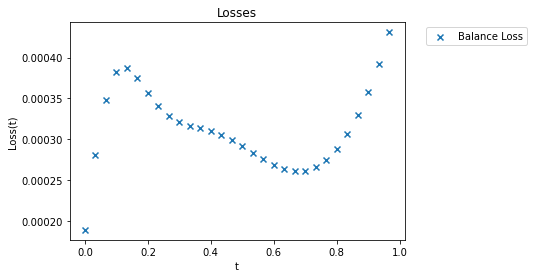

loss after iteration 1400: 1.426439 0.000311998


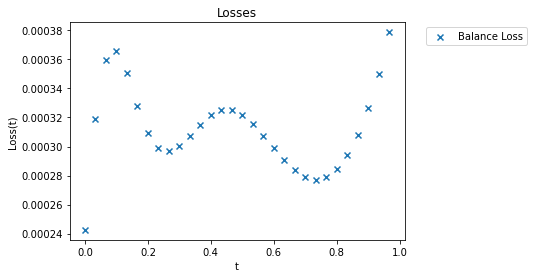

loss after iteration 1600: 1.426433 0.000311764


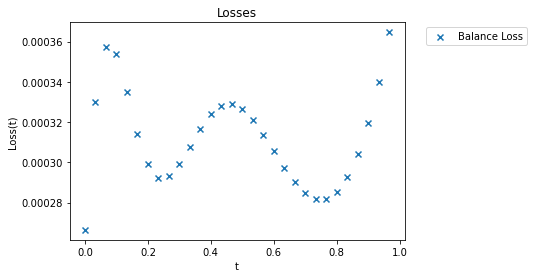

loss after iteration 1800: 1.426431 0.000311661


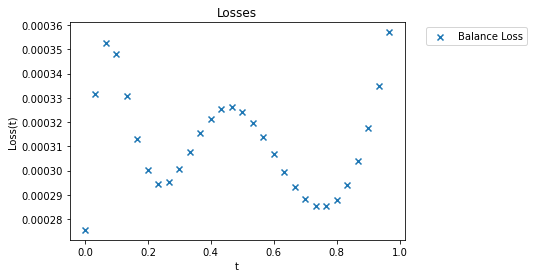

loss after iteration 2000: 1.426455 0.000310977


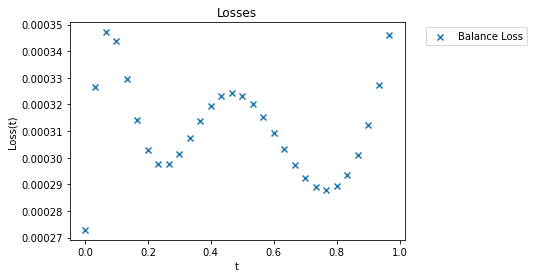

loss after iteration 2200: 1.426352 0.000313698


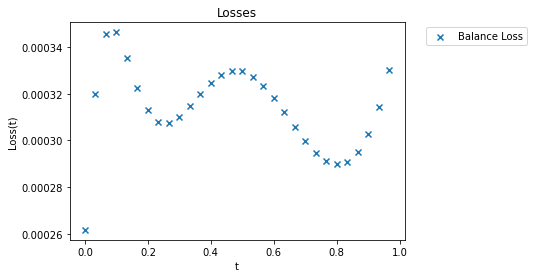

loss after iteration 2400: 1.426430 0.000311482


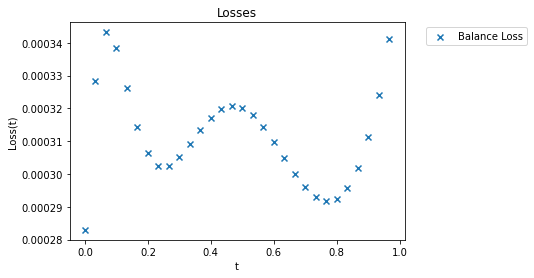

loss after iteration 2600: 1.426455 0.000310892


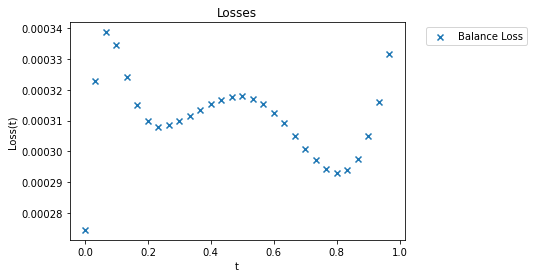

loss after iteration 2800: 1.427264 0.000291001


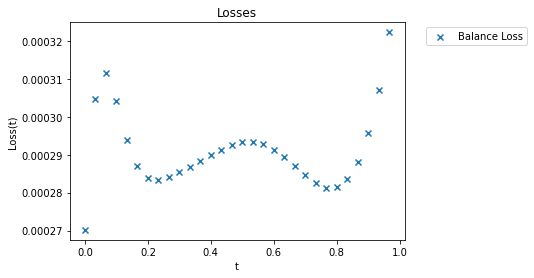

loss after iteration 3000: 1.426431 0.000311362


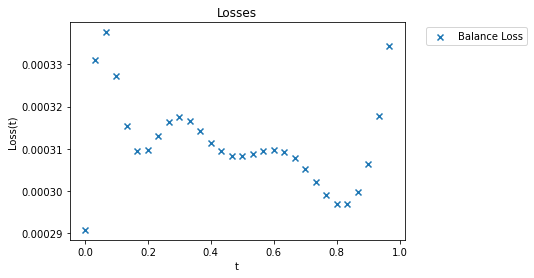

In [32]:
def train_step(a,b,NN,optimizer):
    with tf.GradientTape(persistent=True) as tape:
        VarLoss,BalanceLoss,_,_=custom_loss(NN)
        loss = tf.add(a*VarLoss,b*BalanceLoss)
    grad_NN=tape.gradient(loss,NN.trainable_variables)
    del tape
    optimizer.apply_gradients(zip(grad_NN, NN.trainable_variables))
    return loss

def train(a,b,NN,optimizer,training_steps):
    for i in range(training_steps):
        train_step(a,b,NN,optimizer)
        if i % display_step == 0:
            VarLoss,BalanceLoss,_,VBalanceLoss=custom_loss(NN)
            print("loss after iteration %i: %f %g" % (i,  VarLoss, BalanceLoss))
            #VVarLoss=[c.numpy()[0][0] for c in VVarLoss]
            VBalanceLoss=[c.numpy()[0][0] for c in VBalanceLoss]
            # Initiate plot object
            #plt.scatter(np.append(timesteps,T), VVarLoss, label = "Variational Loss",color ='tab:red', marker='x')
            plt.scatter(timesteps, VBalanceLoss, label = "Balance Loss",color ='tab:blue', marker='x')
            plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
            plt.xlabel('t');
            plt.ylabel('Loss(t)');
            #ax = plt.axes()
            #ax.set_facecolor("lightgrey")
            plt.title('Losses')
            plt.show()
    

tf.random.set_seed(0)
adam_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
train(aVariational,aBalance,multilayer_perceptron,adam_optimizer,training_steps)    
    

Compute the price using the Karush-Kuhn_Tucker condition 
$$ D_{\bf v}\left( \frac{1}{N} \sum_{i=1}^N \sum_{k=0}^{M-1} h*L(X^i_k,v^i_k) + \Psi(X^i_M)\right) + \sum_{k=0}^{M-1} \varpi_k D_{\bf v} g_k({\bf v}) = {\bf 0}, $$
where 
$${\bf v}=(v^1_0,\ldots,v^1_{M-1},\ldots,v^N_0,\ldots,v^N_{M-1}),$$
$$ X^i_k=X^i_k(v^i_0,\ldots,v^i_{k-1}),$$
$$g_k({\bf v})=\frac{1}{N} \sum_{i=1}^N v^i_k - Q_k,\quad k=0,\ldots,M-1$$

For the LQ model, we have
$$ \varpi=-\frac{1}{h} D_{\bf v^i} \left( \sum_{k=0}^{M-1} h*L(X^i_k,v^i_k) + \Psi(X^i_M)\right):=-\frac{1}{h}D_{\bf v^i} L(i)$$
for $1\leq i \leq N$.

In [33]:
#Compute (X,V) for all agents

#initialize time 0
ptemp=tf.reshape(x0,[1,N])
Xvector=ptemp
NNV0=multilayer_perceptron(tf.concat([tf.constant([[0.]],dtype='float32'),tf.reshape(x0,[1,N])],axis=1))
Vvector=NNV0

#Compute velocities per time t in (h,...,T-h)
for t in timesteps[1:M]:
    #Update positions using Forward dynamics. This position corresponds to the current time t
    ptemp=tf.add(ptemp,NNV0*h)
    Xvector=tf.concat([Xvector,ptemp],axis=0)
    #Update velocities using current t,x and N
    NNV0=multilayer_perceptron(tf.concat([tf.constant([[t]],dtype='float32'),tf.reshape(ptemp,[1,N])],axis=1))
    Vvector=tf.concat([Vvector,NNV0],axis=0)

#Update last position
ptemp=tf.add(ptemp,NNV0*h)
Xvector=tf.concat([Xvector,ptemp],axis=0)

Xvector=Xvector.numpy()
Vvector=Vvector.numpy()


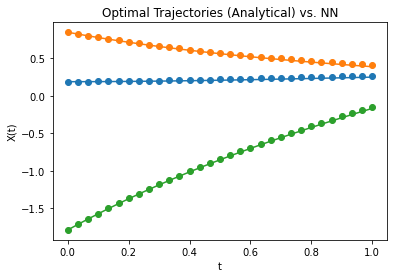

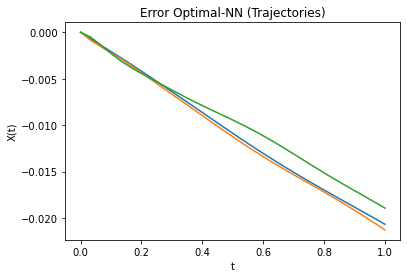

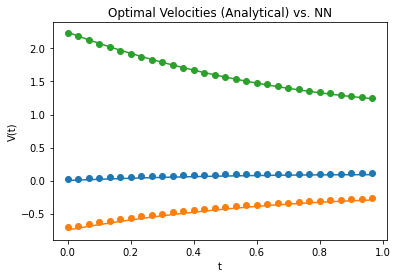

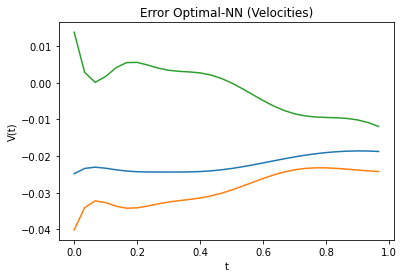

In [34]:
# Initiate plot object
plt.plot(timestepsT, OptimalXX.T)
plt.scatter(timestepsT, Xvector[:,0])
plt.scatter(timestepsT, Xvector[:,1])
plt.scatter(timestepsT, Xvector[:,2])
plt.xlabel('t');
plt.ylabel('X(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Optimal Trajectories (Analytical) vs. NN')
plt.show()

XErr=OptimalXX-Xvector.T

# Initiate plot object
plt.plot(timestepsT, XErr.T)
plt.xlabel('t');
plt.ylabel('X(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Error Optimal-NN (Trajectories)')
plt.show()

# Initiate plot object
plt.plot(timesteps, OptimalVV.T)
plt.scatter(timesteps, Vvector[:,0])
plt.scatter(timesteps, Vvector[:,1])
plt.scatter(timesteps, Vvector[:,2])
plt.xlabel('t');
plt.ylabel('V(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Optimal Velocities (Analytical) vs. NN')
plt.show()

VErr=OptimalVV-Vvector.T
# Initiate plot object
plt.plot(timesteps, VErr.T)
plt.xlabel('t');
plt.ylabel('V(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Error Optimal-NN (Velocities)')
plt.show()


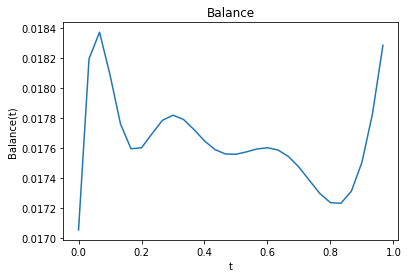

In [35]:
VBalance=np.mean(Vvector,axis=1)-Q(timesteps)
# Initiate plot object
plt.plot(timesteps, VBalance)
plt.xlabel('t');
plt.ylabel('Balance(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Balance')
plt.show()

In [42]:
#Select a player and initialize its v variable
Player=0;
VvectorPlayer=tf.Variable([1. for c in range(M)],dtype='float32')
with tf.GradientTape(persistent=True) as tape:
    tape.watch(VvectorPlayer)
    
    #initialize time 0
    ptemp=tf.reshape(x0[Player],[1])
    VvectorPlayer[0].assign(Vvector[0,Player])
    Li=h*L(ptemp,VvectorPlayer[0])

    #Compute velocities per time t in (h,...,T-h)
    for cc in range(1,M):
        #Update positions using Forward dynamics. This position corresponds to the current time t
        ptemp=tf.add(ptemp,VvectorPlayer[cc-1]*h)
        #Update velocities using current t,x and N
        VvectorPlayer[cc].assign(Vvector[cc,Player])
        #compute running cost
        Li=tf.add(Li,h*L(ptemp,VvectorPlayer[cc]))
    #Update last position
    ptemp=tf.add(ptemp,VvectorPlayer[M-1]*h)
    #compute terminal cost
    Li=tf.add(Li,uT(ptemp))    

dLi_dvi = tape.gradient(Li, VvectorPlayer)
dLi_dvi

priceNN=(-1/h)*dLi_dvi
priceNN=priceNN.numpy()[0:M]
priceNN

array([1.4458534, 1.441916 , 1.4371725, 1.4321104, 1.4271909, 1.4226768,
       1.4186294, 1.4150006, 1.4117235, 1.4087603, 1.4061106, 1.4037994,
       1.4018567, 1.4003052, 1.3991537, 1.3983988, 1.398027 , 1.3980192,
       1.3983517, 1.3989999, 1.3999383, 1.4011438, 1.4025964, 1.404281 ,
       1.4061873, 1.4083098, 1.410645 , 1.4131907, 1.4159443, 1.4189019],
      dtype=float32)

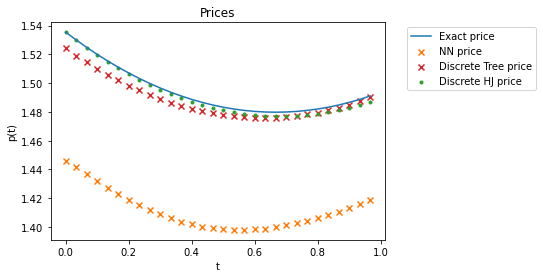

In [43]:
# Initiate plot object
plt.scatter(timesteps, priceNN, label = "NN price",color ='tab:orange', marker='x')
plt.scatter(timesteps, DiscreteTreeprice, label = "Discrete Tree price",color ='tab:red', marker='x')
plt.scatter(timesteps, DiscreteHJprice, label = "Discrete HJ price",color ='tab:green', marker='.')
plt.plot(timesteps, PriceExact, label = "Exact price")
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.xlabel('t');
plt.ylabel('p(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Prices')
plt.show()

